In [1]:
module Lilly1966_solver

using LinearAlgebra

export full_EQ_set, OSE_set

function full_EQ_set( α_in, ε_in, Re_in, N_in )
# Solve the complete set of the equations (2.25)-(2.28) in Lilly (1966)
    #-- arguments input:
    # α_in: wavenumber for y-direction [non-dim,Vector{Float64}]
    # ε_in: flow angle for Vg [degree,Vector{Float64}]
    # Re_in: Reinolds number [non-dim,Vector{Float64}]
    # N_in: grid numbers in vertical [1,Int64]
    #-- arguments output:
    # c_out: wave speed [non-dim,Array{Complex{Float64},size(α),size(ε),size(Re)}]

    # set parameters
    d2r = π / 180.0  # degree to radian
    na = size(α_in)[1]
    ne = size(ε_in)[1]
    nr = size(Re_in)[1]
    N = N_in

    # initialize variables and matrix
    ntot = 2*N-1  # matrix dimension
    c_out = reshape(zeros(Complex{Float64},na,ne,nr),na,ne,nr)

    # initialize working arrays in this function
    ### --- From here, supposing matrix element as row, col as in mathematical notation
    A = reshape(zeros(Complex{Float64},ntot,ntot),ntot,ntot)  # linear operator in differential equations
    B = reshape(zeros(Complex{Float64},ntot,ntot),ntot,ntot)  # linear operator in differential equations
    A_φφ = reshape(zeros(Complex{Float64},N-1,N-1),N-1,N-1)  # partial matrix (phi operator on phi EQ.) in A
    A_φμ = reshape(zeros(Complex{Float64},N-1,N),N-1,N)      # partial matrix (mu operator on phi EQ.) in A
    A_μφ = reshape(zeros(Complex{Float64},N,N-1),N,N-1)      # partial matrix (phi operator on mu EQ.) in A
    A_μμ = reshape(zeros(Complex{Float64},N,N),N,N)          # partial matrix (mu operator on mu EQ.) in A
    B_φφ = reshape(zeros(Complex{Float64},N-1,N-1),N-1,N-1)  # partial matrix (phi operator on phi EQ.) in B
    B_φμ = reshape(zeros(Complex{Float64},N-1,N),N-1,N)      # partial matrix (mu operator on phi EQ.) in B == 0
    B_μφ = reshape(zeros(Complex{Float64},N,N-1),N,N-1)      # partial matrix (phi operator on mu EQ.) in B == 0
    B_μμ = reshape(zeros(Complex{Float64},N,N),N,N)          # partial matrix (mu operator on mu EQ.) in B
    ### --- From here, supposing matrix element as col, row as in julia notation (only using these arrays for matrix calc)
    A_J = reshape(zeros(Complex{Float64},ntot,ntot),ntot,ntot)  # linear operator in differential equations
    B_J = reshape(zeros(Complex{Float64},ntot,ntot),ntot,ntot)  # linear operator in differential equations

    U_bar = reshape(zeros(N,1),N,1)          # Mean flow in x-direction defined at i+1/2
    V_bar = reshape(zeros(N-1,1),N-1,1)      # Mean flow in y-direction defined at i
    Vh_bar = reshape(zeros(N,1),N,1)      # Mean flow in y-direction defined at i+1/2
    dUdz  = reshape(zeros(N,1),N,1)          # Mean flow shear in x-direction defined at i+1/2
    dVdz  = reshape(zeros(N-1,1),N-1,1)      # Mean flow shear in y-direction defined at i
    d2Vdz2  = reshape(zeros(N-1,1),N-1,1)      # Mean flow shear in y-direction defined at i

    #-- Start loops for varying parameters (α, ε, Re)
    for k in 1:nr
        for j in 1:ne
            for i in 1:na
                α = α_in[i]
                ε = ε_in[j] * d2r
                Re = Re_in[k]
                Δ = 1.0/sqrt(α * N)  # grid spacing
                
                # set grid spacing and mean-wind profiles in vertical
                z_p   = [i*Δ for i in 1:N-1]  # non-dimensional vertical coordinate for φ
                zh_p  = [(i-0.5)*Δ for i in 1:N]  # non-dimensional vertical coordinate for μ
                z_p = reshape(z_p,N-1,1)
                zh_p = reshape(zh_p,N,1)
                
                #-- From here, considering to move them as external argument
                U_bar[1:N,1] .= cos(ε) .- exp.(-zh_p[1:N,1]) .* cos.(zh_p[1:N,1] .+ ε)
                V_bar[1:N-1,1] .= -sin(ε) .+ exp.(-z_p[1:N-1,1]) .* sin.(z_p[1:N-1,1] .+ ε)
                Vh_bar[1:N,1] .= -sin(ε) .+ exp.(-zh_p[1:N,1]) .* sin.(zh_p[1:N,1] .+ ε)
                dUdz[1:N,1] .= exp.(-zh_p[1:N,1]) .* cos.(zh_p[1:N,1] .+ ε) .+ exp.(-zh_p[1:N,1]) .* sin.(zh_p[1:N,1] .+ ε)
                dVdz[1:N-1,1] .= -exp.(-z_p[1:N-1,1]) .* sin.(z_p[1:N-1,1] .+ ε) .+ exp.(-z_p[1:N-1,1]) .* cos.(z_p[1:N-1,1] .+ ε)
                d2Vdz2[1:N-1,1] .= .- 2.0 .* exp.(-z_p[1:N-1,1]) .* cos.(z_p[1:N-1,1] .+ ε)

                # setting matrix elements in A and B
                Δ2 = Δ*Δ
                Δ4 = Δ2*Δ2
                αΔ = α*Δ
                V_infl = -sin(ε) + exp(-(0.5*π-ε))
                #      μ[1]        μ[2]       μ[3]        μ[4]
                # ----- 0 --------- 1 --------- 2 --------- 3 -- i for μ = μ[i+1]
                # ------|-----------|-----------|-----------|---   for μ = μ[i+1]
                # 0---------- 1 --------- 2 --------- 3 -------- i for φ = φ[i]
                # |-----------|-----------|-----------|---------   for φ = φ[i]

                # For φ EQ.
                for i in 3:N-3
                    #    println("$i")
                    A_φφ[i,i+2] = complex(1.0,α*Re*V_bar[i,1]*Δ2/12.0)
                    A_φφ[i,i-2] = A_φφ[i,i+2]
                    A_φφ[i,i+1] = complex(-4.0-2.0*((αΔ)^2),-4.0*α*Re*V_bar[i,1]*Δ2/3.0)
                    A_φφ[i,i-1] = A_φφ[i,i+1]
                    A_φφ[i,i]   = complex(6.0+4.0*((αΔ)^2)+(α^4-d2Vdz2[i,1])*Δ4,α*Re*V_bar[i,1]*(2.5+(αΔ)^2)*Δ2)
                    A_φμ[i,i]   = -2.0*(Δ^3)  # A^{φ,μ}_{i,i-1/2}
                    A_φμ[i,i+1] = +2.0*(Δ^3)  # A^{φ,μ}_{i,i+1/2}
                    B_φφ[i,i+2] = complex(0.0,α*Re*Δ2/12.0)
                    B_φφ[i,i-2] = B_φφ[i,i+2]
                    B_φφ[i,i+1] = -complex(0.0,4.0*α*Re*Δ2/3.0)
                    B_φφ[i,i-1] = B_φφ[i,i+1]
                    B_φφ[i,i]   = complex(0.0,α*Re*(2.5+(αΔ)^2)*Δ2)
                end

                # For μ EQ.
                for i in 3:N-2
                    A_μφ[i,i] = -complex(2.0*Δ,9.0*α*Re*dUdz[i,1]*Δ2/16.0)  # A^{μ,φ}_{i+1/2,i+1}
                    A_μφ[i,i-2] = complex(0.0,α*Re*dUdz[i,1]*Δ2/16.0)  # A^{μ,φ}_{i+1/2,i-1}
                    A_μφ[i,i+1] = A_μφ[i,i-2]  # A^{μ,φ}_{i+1/2,i+2}
                    A_μφ[i,i-1] = complex(2.0*Δ,-9.0*α*Re*dUdz[i,1]*Δ2/16.0)  # A^{μ,φ}_{i+1/2,i}
                    A_μμ[i,i+1] = 1.0  # A^{μ,μ}_{i+1/2,i-1/2}
                    A_μμ[i,i-1] = 1.0  # A^{μ,μ}_{i+1/2,i+3/2}
                    A_μμ[i,i]   = -complex(2.0+(αΔ)^2,α*Re*Vh_bar[i,1]*Δ2)
                    B_μμ[i,i]   = -complex(0.0,α*Re*Δ2)
                end

                # Adjacent of boundaries
                # For φ EQ. (at z=z_1)
                A_φφ[1,3] = complex(1.0,α*Re*V_bar[1,1]*Δ2/12.0)
                A_φφ[1,2] = complex(-4.0-2.0*((αΔ)^2),-4.0*α*Re*V_bar[1,1]*Δ2/3.0)
                A_φφ[1,1] = complex(7.0+4.0*((αΔ)^2)+(α^4-d2Vdz2[1,1])*Δ4,α*Re*V_bar[1,1]*(31.0/12.0+(αΔ)^2)*Δ2)
                A_φμ[1,1] = -2.0*(Δ^3)
                A_φμ[1,2] = +2.0*(Δ^3)
                B_φφ[1,3] = complex(0.0,α*Re*Δ2/12.0)
                B_φφ[1,2] = -complex(0.0,4.0*α*Re*Δ2/3.0)
                B_φφ[1,1] = complex(0.0,α*Re*(31.0/12.0+(αΔ)^2)*Δ2)
                # For μ EQ. (at z=z_{1/2})
                A_μφ[1,1] = -complex(2.0*Δ,0.5*α*Re*dUdz[1,1]*Δ2)
                A_μφ[1,2] = complex(0.0,α*Re*dUdz[1,1]*Δ2/16.0)
                A_μμ[1,2] = 1.0
                A_μμ[1,1] = -complex(3.0+(αΔ)^2,α*Re*Vh_bar[1,1]*Δ2)
                B_μμ[1,1] = -complex(0.0,α*Re*Δ2)

                # For φ EQ. (at z=z_2)
                A_φφ[2,4] = complex(1.0,α*Re*V_bar[2,1]*Δ2/12.0)
                A_φφ[2,3] = complex(-4.0-2.0*((αΔ)^2),-4.0*α*Re*V_bar[2,1]*Δ2/3.0)
                A_φφ[2,1] = A_φφ[2,3]
                A_φφ[2,2] = complex(6.0+4.0*((αΔ)^2)+(α^4-d2Vdz2[2,1])*Δ4,α*Re*V_bar[2,1]*(2.5+(αΔ)^2)*Δ2)
                A_φμ[2,2] = -2.0*(Δ^3)
                A_φμ[2,3] = +2.0*(Δ^3)
                B_φφ[2,4] = complex(0.0,α*Re*Δ2/12.0)
                B_φφ[2,3] = -complex(0.0,4.0*α*Re*Δ2/3.0)
                B_φφ[2,1] = B_φφ[2,3]
                B_φφ[2,2] = complex(0.0,α*Re*(2.5+(αΔ)^2)*Δ2)
                # For μ EQ. (at z=z_{1+1/2})
                A_μφ[2,2] = -complex(2.0*Δ,9.0*α*Re*dUdz[2,1]*Δ2/16.0)
                A_μφ[2,3] = complex(0.0,α*Re*dUdz[2,1]*Δ2/16.0)
                A_μφ[2,1] = complex(2.0*Δ,-9.0*α*Re*dUdz[2,1]*Δ2/16.0)
                A_μμ[2,3] = 1.0
                A_μμ[2,1] = 1.0
                A_μμ[2,2] = -complex(2.0+(αΔ)^2,α*Re*Vh_bar[2,1]*Δ2)
                B_μμ[2,2] = -complex(0.0,α*Re*Δ2)

                # For φ EQ. (at z=z_{N-2})
                A_φφ[N-2,N-4] = complex(1.0,α*Re*V_bar[N-2,1]*Δ2/12.0)
                A_φφ[N-2,N-1] = complex(-4.0-2.0*((αΔ)^2),-4.0*α*Re*V_bar[N-2,1]*Δ2/3.0)
                A_φφ[N-2,N-3] = A_φφ[N-2,N-1]
                A_φφ[N-2,N-2] = complex(6.0+4.0*((αΔ)^2)+(α^4-d2Vdz2[N-2,1])*Δ4,α*Re*V_bar[N-2,1]*(2.5+(αΔ)^2)*Δ2)
                A_φμ[N-2,N-2] = -2.0*(Δ^3)
                A_φμ[N-2,N-1] = +2.0*(Δ^3)
                B_φφ[N-2,N-4] = complex(0.0,α*Re*Δ2/12.0)
                B_φφ[N-2,N-1] = -complex(0.0,4.0*α*Re*Δ2/3.0)
                B_φφ[N-2,N-3] = B_φφ[N-2,N-1]
                B_φφ[N-2,N-2] = complex(0.0,α*Re*(2.5+(αΔ)^2)*Δ2)
                # For μ EQ. (at z=z_{N-1-1/2})
                A_μφ[N-1,N-1] = -complex(2.0*Δ,9.0*α*Re*dUdz[N-1,1]*Δ2/16.0)
                A_μφ[N-1,N-3] = complex(0.0,α*Re*dUdz[N-1,1]*Δ2/16.0)
                A_μφ[N-1,N-2] = complex(2.0*Δ,-9.0*α*Re*dUdz[N-1,1]*Δ2/16.0)
                A_μμ[N-1,N-2] = 1.0
                A_μμ[N-1,N]   = 1.0
                A_μμ[N-1,N-1] = -complex(2.0+(αΔ)^2,α*Re*Vh_bar[N-1,1]*Δ2)
                B_μμ[N-1,N-1] = -complex(0.0,α*Re*Δ2)

                # For φ EQ. (at z=z_{N-1})
                A_φφ[N-1,N-3] = complex(1.0,α*Re*V_bar[N-1,1]*Δ2/12.0)
                A_φφ[N-1,N-2] = complex(-4.0-2.0*((αΔ)^2),-4.0*α*Re*V_bar[N-1,1]*Δ2/3.0)
                A_φφ[N-1,N-1] = complex(5.0+4.0*((αΔ)^2)+(α^4-d2Vdz2[N-1,1])*Δ4,α*Re*V_bar[N-1,1]*(29.0/12.0+(αΔ)^2)*Δ2)
                A_φμ[N-1,N-1] = -2.0*(Δ^3)
                A_φμ[N-1,N]   = +2.0*(Δ^3)
                B_φφ[N-1,N-3] = complex(0.0,α*Re*Δ2/12.0)
                B_φφ[N-1,N-2] = -complex(0.0,4.0*α*Re*Δ2/3.0)
                B_φφ[N-1,N-1] = complex(0.0,α*Re*(29.0/12.0+(αΔ)^2)*Δ2)
                # For μ EQ. (at z=z_{N-1/2})
                A_μφ[N,N-2]   = complex(0.0,α*Re*dUdz[N]*Δ2/16.0)
                A_μφ[N,N-1]   = complex(2.0*Δ,-5.0*α*Re*dUdz[N]*Δ2/8.0)
                A_μμ[N,N-1]   = 1.0
                A_μμ[N,N]     = -complex(1.0+(αΔ)^2,α*Re*Vh_bar[N]*Δ2)
                B_μμ[N,N]     = -complex(0.0,α*Re*Δ2)

                # assigned partial matrices A^ and B^ to A and B
                A[1:N-1,1:N-1] = A_φφ[1:N-1,1:N-1]
                A[1:N-1,N:2*N-1] = A_φμ[1:N-1,1:N]
                A[N:2*N-1,1:N-1] = A_μφ[1:N,1:N-1]
                A[N:2*N-1,N:2*N-1] = A_μμ[1:N,1:N]
                # non-diagonal parts in B are zero
                B[1:N-1,1:N-1] = B_φφ[1:N-1,1:N-1]
                B[N:2*N-1,N:2*N-1] = B_μμ[1:N,1:N]

                A_J = transpose(A)  # mathematical A -> Julia A_J
                B_J = transpose(B)  # mathematical A -> Julia A_J
                C_J = inv(B_J) * A_J
                D_J = eigvals(C_J)
                F_J = imag.(D_J)
                E_J = inv(B_J) * B_J
                nc_max = findmax(F_J)[2]
                c_out[i,j,k] = D_J[nc_max]

            end
        end
    end

#println(D_J[findmax(F_J)[2]])
#println(F_J)
#println(V_infl)

    return c_out

end  # function full_EQ_set
    
function OSE_set( α_in, ε_in, Re_in, N_in )
# Solve the approximation (OSE) set of the equations (2.25), (2.27)-(2.28) in Lilly (1966)
    #-- arguments input:
    # α_in: wavenumber for y-direction [non-dim,Vector{Float64}]
    # ε_in: flow angle for Vg [degree,Vector{Float64}]
    # Re_in: Reinolds number [non-dim,Vector{Float64}]
    # N_in: grid numbers in vertical [1,Int64]
    #-- arguments output:
    # c_out: wave speed [non-dim,Array{Complex{Float64},size(α),size(ε),size(Re)}]

    # set parameters
    d2r = π / 180.0  # degree to radian
    na = size(α_in)[1]
    ne = size(ε_in)[1]
    nr = size(Re_in)[1]
    N = N_in

    # initialize variables and matrix
    ntot = N-1  # matrix dimension
    c_out = reshape(zeros(Complex{Float64},(na,ne,nr)),na,ne,nr)

    # initialize working arrays in this function
    ### --- From here, supposing matrix element as row, col as in mathematical notation
    A = reshape(zeros(Complex{Float64},ntot,ntot),ntot,ntot)  # linear operator in differential equations
    B = reshape(zeros(Complex{Float64},ntot,ntot),ntot,ntot)  # linear operator in differential equations
    A_φφ = reshape(zeros(Complex{Float64},N-1,N-1),N-1,N-1)  # partial matrix (phi operator on phi EQ.) in A
    B_φφ = reshape(zeros(Complex{Float64},N-1,N-1),N-1,N-1)  # partial matrix (phi operator on phi EQ.) in B
    ### --- From here, supposing matrix element as col, row as in julia notation (only using these arrays for matrix calc)
    A_J = reshape(zeros(Complex{Float64},ntot,ntot),ntot,ntot)  # linear operator in differential equations
    B_J = reshape(zeros(Complex{Float64},ntot,ntot),ntot,ntot)  # linear operator in differential equations

    U_bar = reshape(zeros(N,1),N,1)          # Mean flow in x-direction defined at i+1/2
    V_bar = reshape(zeros(N-1,1),N-1,1)      # Mean flow in y-direction defined at i
    Vh_bar = reshape(zeros(N,1),N,1)      # Mean flow in y-direction defined at i+1/2
    dUdz  = reshape(zeros(N,1),N,1)          # Mean flow shear in x-direction defined at i+1/2
    dVdz  = reshape(zeros(N-1,1),N-1,1)      # Mean flow shear in y-direction defined at i
    d2Vdz2  = reshape(zeros(N-1,1),N-1,1)      # Mean flow shear in y-direction defined at i

    #-- Start loops for varying parameters (α, ε, Re)
    for k in 1:nr
        for j in 1:ne
            for i in 1:na
                α = α_in[i]
                ε = ε_in[j] * d2r
                Re = Re_in[k]
                Δ = 1.0/sqrt(α * N)  # grid spacing
                
                # set grid spacing and mean-wind profiles in vertical
                z_p   = [i*Δ for i in 1:N-1]  # non-dimensional vertical coordinate for φ
                zh_p  = [(i-0.5)*Δ for i in 1:N]  # non-dimensional vertical coordinate for μ
                z_p = reshape(z_p,N-1,1)
                zh_p = reshape(zh_p,N,1)
                
                #-- From here, considering to move them as external argument
                U_bar[1:N,1] .= cos(ε) .- exp.(-zh_p[1:N,1]) .* cos.(zh_p[1:N,1] .+ ε)
                V_bar[1:N-1,1] .= -sin(ε) .+ exp.(-z_p[1:N-1,1]) .* sin.(z_p[1:N-1,1] .+ ε)
                Vh_bar[1:N,1] .= -sin(ε) .+ exp.(-zh_p[1:N,1]) .* sin.(zh_p[1:N,1] .+ ε)
                dUdz[1:N,1] .= exp.(-zh_p[1:N,1]) .* cos.(zh_p[1:N,1] .+ ε) .+ exp.(-zh_p[1:N,1]) .* sin.(zh_p[1:N,1] .+ ε)
                dVdz[1:N-1,1] .= -exp.(-z_p[1:N-1,1]) .* sin.(z_p[1:N-1,1] .+ ε) .+ exp.(-z_p[1:N-1,1]) .* cos.(z_p[1:N-1,1] .+ ε)
                d2Vdz2[1:N-1,1] .= .- 2.0 .* exp.(-z_p[1:N-1,1]) .* cos.(z_p[1:N-1,1] .+ ε)

                # setting matrix elements in A and B
                Δ2 = Δ*Δ
                Δ4 = Δ2*Δ2
                αΔ = α*Δ
                V_infl = -sin(ε) + exp(-(0.5*π-ε))
                #      μ[1]        μ[2]       μ[3]        μ[4]
                # ----- 0 --------- 1 --------- 2 --------- 3 -- i for μ = μ[i+1]
                # ------|-----------|-----------|-----------|---   for μ = μ[i+1]
                # 0---------- 1 --------- 2 --------- 3 -------- i for φ = φ[i]
                # |-----------|-----------|-----------|---------   for φ = φ[i]

                # For φ EQ.
                for i in 3:N-3
                    #    println("$i")
                    A_φφ[i,i+2] = complex(1.0,α*Re*V_bar[i,1]*Δ2/12.0)
                    A_φφ[i,i-2] = A_φφ[i,i+2]
                    A_φφ[i,i+1] = complex(-4.0-2.0*((αΔ)^2),-4.0*α*Re*V_bar[i,1]*Δ2/3.0)
                    A_φφ[i,i-1] = A_φφ[i,i+1]
                    A_φφ[i,i]   = complex(6.0+4.0*((αΔ)^2)+(α^4-d2Vdz2[i,1])*Δ4,α*Re*V_bar[i,1]*(2.5+(αΔ)^2)*Δ2)
                    B_φφ[i,i+2] = complex(0.0,α*Re*Δ2/12.0)
                    B_φφ[i,i-2] = B_φφ[i,i+2]
                    B_φφ[i,i+1] = -complex(0.0,4.0*α*Re*Δ2/3.0)
                    B_φφ[i,i-1] = B_φφ[i,i+1]
                    B_φφ[i,i]   = complex(0.0,α*Re*(2.5+(αΔ)^2)*Δ2)
                end

                # Adjacent of boundaries
                # For φ EQ. (at z=z_1)
                A_φφ[1,3] = complex(1.0,α*Re*V_bar[1,1]*Δ2/12.0)
                A_φφ[1,2] = complex(-4.0-2.0*((αΔ)^2),-4.0*α*Re*V_bar[1,1]*Δ2/3.0)
                A_φφ[1,1] = complex(7.0+4.0*((αΔ)^2)+(α^4-d2Vdz2[1,1])*Δ4,α*Re*V_bar[1,1]*(31.0/12.0+(αΔ)^2)*Δ2)
                B_φφ[1,3] = complex(0.0,α*Re*Δ2/12.0)
                B_φφ[1,2] = -complex(0.0,4.0*α*Re*Δ2/3.0)
                B_φφ[1,1] = complex(0.0,α*Re*(31.0/12.0+(αΔ)^2)*Δ2)

                # For φ EQ. (at z=z_2)
                A_φφ[2,4] = complex(1.0,α*Re*V_bar[2,1]*Δ2/12.0)
                A_φφ[2,3] = complex(-4.0-2.0*((αΔ)^2),-4.0*α*Re*V_bar[2,1]*Δ2/3.0)
                A_φφ[2,1] = A_φφ[2,3]
                A_φφ[2,2] = complex(6.0+4.0*((αΔ)^2)+(α^4-d2Vdz2[2,1])*Δ4,α*Re*V_bar[2,1]*(2.5+(αΔ)^2)*Δ2)
                B_φφ[2,4] = complex(0.0,α*Re*Δ2/12.0)
                B_φφ[2,3] = -complex(0.0,4.0*α*Re*Δ2/3.0)
                B_φφ[2,1] = B_φφ[2,3]
                B_φφ[2,2] = complex(0.0,α*Re*(2.5+(αΔ)^2)*Δ2)

                # For φ EQ. (at z=z_{N-2})
                A_φφ[N-2,N-4] = complex(1.0,α*Re*V_bar[N-2,1]*Δ2/12.0)
                A_φφ[N-2,N-1] = complex(-4.0-2.0*((αΔ)^2),-4.0*α*Re*V_bar[N-2,1]*Δ2/3.0)
                A_φφ[N-2,N-3] = A_φφ[N-2,N-1]
                A_φφ[N-2,N-2] = complex(6.0+4.0*((αΔ)^2)+(α^4-d2Vdz2[N-2,1])*Δ4,α*Re*V_bar[N-2,1]*(2.5+(αΔ)^2)*Δ2)
                B_φφ[N-2,N-4] = complex(0.0,α*Re*Δ2/12.0)
                B_φφ[N-2,N-1] = -complex(0.0,4.0*α*Re*Δ2/3.0)
                B_φφ[N-2,N-3] = B_φφ[N-2,N-1]
                B_φφ[N-2,N-2] = complex(0.0,α*Re*(2.5+(αΔ)^2)*Δ2)

                # For φ EQ. (at z=z_{N-1})
                A_φφ[N-1,N-3] = complex(1.0,α*Re*V_bar[N-1,1]*Δ2/12.0)
                A_φφ[N-1,N-2] = complex(-4.0-2.0*((αΔ)^2),-4.0*α*Re*V_bar[N-1,1]*Δ2/3.0)
                A_φφ[N-1,N-1] = complex(5.0+4.0*((αΔ)^2)+(α^4-d2Vdz2[N-1,1])*Δ4,α*Re*V_bar[N-1,1]*(29.0/12.0+(αΔ)^2)*Δ2)
                B_φφ[N-1,N-3] = complex(0.0,α*Re*Δ2/12.0)
                B_φφ[N-1,N-2] = -complex(0.0,4.0*α*Re*Δ2/3.0)
                B_φφ[N-1,N-1] = complex(0.0,α*Re*(29.0/12.0+(αΔ)^2)*Δ2)

                # assigned partial matrices A^ and B^ to A and B
                A[1:N-1,1:N-1] = A_φφ[1:N-1,1:N-1]
                # non-diagonal parts in B are zero
                B[1:N-1,1:N-1] = B_φφ[1:N-1,1:N-1]

                A_J = transpose(A)  # mathematical A -> Julia A_J
                B_J = transpose(B)  # mathematical A -> Julia A_J
                C_J = inv(B_J) * A_J
                D_J = eigvals(C_J)
                F_J = imag.(D_J)
                E_J = inv(B_J) * B_J
                nc_max = findmax(F_J)[2]
                c_out[i,j,k] = D_J[nc_max]

            end
        end
    end

#println(D_J[findmax(F_J)[2]])
#println(F_J)
#println(V_infl)

    return c_out

end  # function OSE_set
    
end  # module Lilly1966_solver

Main.Lilly1966_solver

In [2]:
using .Lilly1966_solver

#-- Drawing parameters    
na = 20  # wavenumber interval
ne = 20  # angle interval
nr = 20  # Reinolds number interval
α_min = 0.001
α_max = 1.0
ε_min = -60.0
ε_max = 60.0
Re_min = 25.0
Re_max = 500.0

α = [α_min+(α_max-α_min)*((i-1.0)/(na-1.0)) for i in 1:na]
ε = [ε_min+(ε_max-ε_min)*((i-1.0)/(ne-1.0)) for i in 1:ne]
Re = [Re_min+(Re_max-Re_min)*((i-1.0)/(nr-1.0)) for i in 1:nr]

c_full = full_EQ_set( α, ε, Re, 35 )
c_ose = OSE_set( α, ε, Re, 35 )



20×20×20 Array{Complex{Float64},3}:
[:, :, 1] =
 0.864005+0.749363im   0.804944+0.14258im    …  -0.866025-0.0236016im
 0.864131-0.0178902im  0.803465-0.0170507im     -0.869369-0.0216414im
 0.863543-0.0192996im  0.802856-0.0185836im     -0.871508-0.0239824im
 0.863595-0.0210307im  0.802932-0.0203377im     -0.873849-0.0264434im
 0.864056-0.0230905im   0.80343-0.022402im      -0.876698-0.0286047im
  0.86475-0.0254921im  0.804155-0.024811im   …  -0.879753-0.0293886im
 0.865561-0.0282094im  0.804976-0.0275412im     -0.881353-0.0290929im
 0.866423-0.031197im   0.805824-0.0305438im     -0.881612-0.0292257im
  0.86731-0.0344051im  0.806668-0.0337645im     -0.881312-0.0301184im
 0.868215-0.037786im   0.807505-0.0371523im     -0.880885-0.0316704im
 0.869146-0.0412972im  0.808344-0.0406621im  …  -0.880543-0.0337225im
 0.870114-0.044902im   0.809203-0.0442561im     -0.880385-0.0361257im
 0.871132-0.0485695im  0.810098-0.0479034im     -0.880442-0.0387554im
 0.872215-0.0522742im  0.811049-0.051579im

[-1.5844293495493304e-6, 0.0015889913115860095, 0.0022927206982129647, 0.003136899295005263, 0.0033814079172513885, 0.0035205763915490346, 0.0035213784945906062, 0.0033751176553336987, 0.0031672749972534026, 0.0028984401502025153, 0.00257101712772535, 0.0022014837123090288, 0.0017979344200940435, 0.0013628946689964404, 0.000900019673950996, 0.0004135349173473162, -9.349615665233196e-5, -0.0006189920555579306, -0.001161144563903043, -0.0017182414228851005]


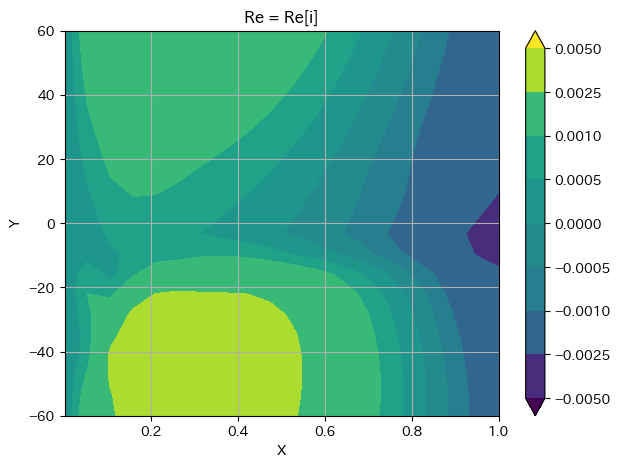

In [5]:
#-- Drawing
##########
#  Plot  #
##########
using PyPlot

rc("font", family="IPAPGothic")
fig = figure("pyplot_majorminor",figsize=(7,5))

nx = na
ny = ne

xax = reshape(zeros(nx,ny),nx,ny)
yax = reshape(zeros(nx,ny),nx,ny)

for i in 1:nx
    xax[i,1:ny] .= α[i]  # xmin + (xmax-xmin) * (i-1) / (nx-1)
end
for i in 1:ny
    yax[1:nx,i] .= ε[i]  # ymin + (ymax-ymin) * (i-1) / (ny-1)
#    yax[1:nx,i] .= Re[i]  # ymin + (ymax-ymin) * (i-1) / (ny-1)
end

cont_val = reshape(zeros(nx,ny),nx,ny)
shade_val = reshape(zeros(nx,ny),nx,ny)

for i in 1:nr#div(nr,2)-1:div(nr,2)+1
    cont_val = real.(c_full[1:na,1:ne,i])
    for j in 1:ne
        shade_val[1:na,j] = α[1:na] .* imag.(c_full[1:na,j,i])
    end
#draw_num2 = 2
#if draw_num2 == 1
#    cp = contourf(xax[1:nx,1:nx], xax'[1:nx,1:nx], Pftime[1:nx,1:nx,1], levels=[-15.0, -10.0, -5.0, 0.0, 5.0, 10.0, 15.0, 20.0], origin="image", cmap=ColorMap("viridis"), extend="both")
    #cp = contourf(xax[1:nx,1:nx], xax'[1:nx,1:nx], Pftime[1:nx,1:nx,2], levels=[-2.0, -1.0, -0.5, -0.25, 0.25, 0.5, 1.0, 1.5, 2.0], origin="image", cmap=ColorMap("viridis"), extend="both")
    #cp = contourf(xax[1:nx,1:no], xax'[1:nx,1:no], Pftime[1:nx,1:nx,2]*Hop'*inv(Hop*Pftime[1:nx,1:nx,2]*Hop'+Ro), origin="image", cmap=ColorMap("viridis"), extend="both")
#elseif draw_num2 == 2
    ##cp = contour(xax[1:nx,1:ny], yax[1:nx,1:ny], shade_val[1:nx,1:ny], 8, levels=[-0.01, -0.005, -0.003, -0.002, -0.001, -0.0005, 0.0, 0.0005, 0.001, 0.002, 0.003, 0.005, 0.01])
    cp = contourf(xax[1:nx,1:ny], yax[1:nx,1:ny], shade_val[1:nx,1:ny], 9, levels=[-0.005, -0.0025, -0.001, -0.0005, 0.0, 0.0005, 0.001, 0.0025, 0.005], cmap=ColorMap("viridis"), extend="both")
    ##cp = contourf(xax[1:nx,1:ny], yax[1:nx,1:ny], cont_val[1:nx,1:ny], 8, levels=[-1.0, -0.5, -0.2, -0.1, 0.0, 0.1, 0.2, 0.5, 1.0], cmap=ColorMap("viridis"), extend="both")
    #cp = contourf(xax[1:nx,1:ny], yax[1:nx,1:ny], shade_val[1:nx,1:ny], 10, cmap=ColorMap("viridis"), extend="both")
#elseif draw_num2 == 3
#    cp = contourf(xoax[1:nx,1:nto-1], toax[1:nx,1:nto-1], evec_max[1:nx,1:nto-1], 10, cmap=ColorMap("viridis"), extend="both")
#elseif draw_num2 == 4
#    cp = contourf(xoax[1:nx,1:40], toax[1:nx,1:40], x_inc[1:nx,1:40], levels=[-2.0, -1.0, -0.5, -0.25, 0.25, 0.5, 1.0, 1.5, 2.0], cmap=ColorMap("viridis"), extend="both")
#elseif draw_num2 == 5
#    cp = contourf(xoax[1:no,1:40], toax[1:no,1:40], y_innov[1:no,1:40], levels=[-2.0, -1.0, -0.5, -0.25, 0.25, 0.5, 1.0, 1.5, 2.0], cmap=ColorMap("viridis"), extend="both")
#end
#ax.label(cp, inline=1, fontsize=10)
#legend()
ax = gca()

xlabel("X")
ylabel("Y")
if i == 1 #div(ne,2)-1
   plt.colorbar(cp)
end
grid("on")

PyPlot.title("Re = Re[i]")

#########################
#  Set tick dimensions  #
#########################
#ax.xaxis.set_tick_params(which="major",length=5,width=2,labelsize=10)
#ax.xaxis.set_tick_params(which="minor",length=5,width=2)

fig.canvas.draw() # Update the figure
gcf() # Needed for IJulia to plot inline
fname = "Re" * string(i) * ".png"
#savefig("B-init_2d.pdf")
savefig(fname)
#psi
end
println(shade_val[1:na,1])

In [5]:
imag.(c_full[10,1:ne,1])
α

20-element Vector{Float64}:
 0.001
 0.05357894736842105
 0.1061578947368421
 0.15873684210526315
 0.2113157894736842
 0.26389473684210524
 0.3164736842105263
 0.36905263157894735
 0.4216315789473684
 0.47421052631578947
 0.5267894736842105
 0.5793684210526316
 0.6319473684210526
 0.6845263157894736
 0.7371052631578947
 0.7896842105263158
 0.8422631578947368
 0.8948421052631579
 0.9474210526315789
 1.0

[-60.0, -53.68421052631579, -47.368421052631575, -41.05263157894737, -34.73684210526316, -28.42105263157895, -22.10526315789474, -15.789473684210527, -9.473684210526315, -3.1578947368421098, 3.1578947368421026, 9.473684210526315, 15.78947368421052, 22.10526315789474, 28.421052631578945, 34.736842105263165, 41.05263157894737, 47.368421052631575, 53.68421052631578, 60.0]
[-1.0471975511965976, -0.9369662300180085, -0.8267349088394192, -0.71650358766083, -0.6062722664822408, -0.49604094530365156, -0.38580962412506237, -0.2755783029464731, -0.16534698176788384, -0.05511566058929469, 0.05511566058929457, 0.16534698176788384, 0.275578302946473, 0.38580962412506237, 0.4960409453036515, 0.6062722664822409, 0.71650358766083, 0.8267349088394192, 0.9369662300180084, 1.0471975511965976]


┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[6]:88
└ @ Core In[6]:88
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[6]:89
└ @ Core In[6]:89
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[6]:91
└ @ Core In[6]:91
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[6]:92
└ @ Core In[6]:92


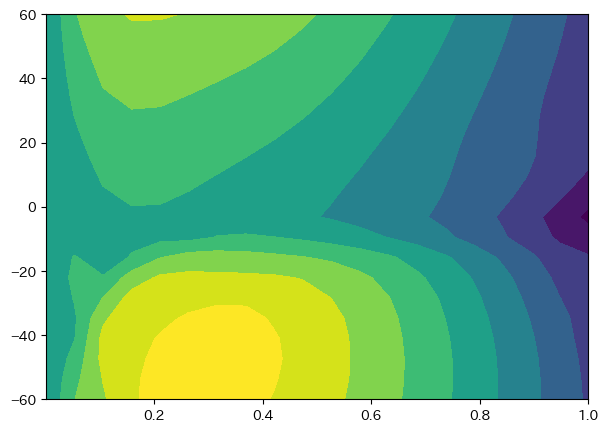

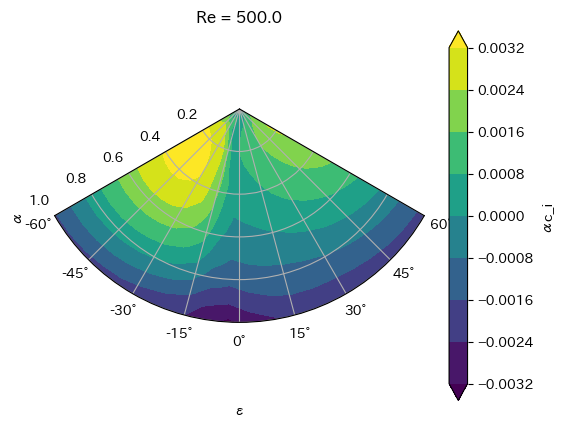

In [6]:
#-- Drawing
##########
#  Plot  #
##########
using PyPlot

rc("font", family="IPAPGothic")
fig = figure("pyplot_majorminor",figsize=(7,5))

nx = na
ny = ne

xax = reshape(zeros(nx,ny),nx,ny)
yax = reshape(zeros(nx,ny),nx,ny)

for i in 1:nx
    xax[i,1:ny] .= α[i]  # xmin + (xmax-xmin) * (i-1) / (nx-1)
end
for i in 1:ny
    yax[1:nx,i] .= ε[i]  # ymin + (ymax-ymin) * (i-1) / (ny-1)
#    yax[1:nx,i] .= Re[i]  # ymin + (ymax-ymin) * (i-1) / (ny-1)
end

cont_val = reshape(zeros(nx,ny),nx,ny)
shade_val = reshape(zeros(nx,ny),nx,ny)

println(yax[1,1:ne])

for i in nr:nr#div(nr,2)-1:div(nr,2)+1
    cont_val = real.(c_full[1:na,1:ne,i])
    for j in 1:ne
        shade_val[1:na,j] = α[1:na] .* imag.(c_full[1:na,j,i])
    end
#draw_num2 = 2
#if draw_num2 == 1
#    cp = contourf(xax[1:nx,1:nx], xax'[1:nx,1:nx], Pftime[1:nx,1:nx,1], levels=[-15.0, -10.0, -5.0, 0.0, 5.0, 10.0, 15.0, 20.0], origin="image", cmap=ColorMap("viridis"), extend="both")
    #cp = contourf(xax[1:nx,1:nx], xax'[1:nx,1:nx], Pftime[1:nx,1:nx,2], levels=[-2.0, -1.0, -0.5, -0.25, 0.25, 0.5, 1.0, 1.5, 2.0], origin="image", cmap=ColorMap("viridis"), extend="both")
    #cp = contourf(xax[1:nx,1:no], xax'[1:nx,1:no], Pftime[1:nx,1:nx,2]*Hop'*inv(Hop*Pftime[1:nx,1:nx,2]*Hop'+Ro), origin="image", cmap=ColorMap("viridis"), extend="both")
#elseif draw_num2 == 2
    ##cp = contour(xax[1:nx,1:ny], yax[1:nx,1:ny], shade_val[1:nx,1:ny], 8, levels=[-0.01, -0.005, -0.003, -0.002, -0.001, -0.0005, 0.0, 0.0005, 0.001, 0.002, 0.003, 0.005, 0.01])
    #cp = contourf(xax[1:nx,1:ny], yax[1:nx,1:ny], shade_val[1:nx,1:ny], 9, levels=[-0.05, -0.025, -0.01, -0.005, 0.0, 0.005, 0.01, 0.025, 0.05], cmap=ColorMap("viridis"), extend="both")
    ##cp = contourf(xax[1:nx,1:ny], yax[1:nx,1:ny], cont_val[1:nx,1:ny], 8, levels=[-1.0, -0.5, -0.2, -0.1, 0.0, 0.1, 0.2, 0.5, 1.0], cmap=ColorMap("viridis"), extend="both")
    cp = contourf(xax[1:nx,1:ny], yax[1:nx,1:ny], shade_val[1:nx,1:ny], 10, cmap=ColorMap("viridis"), extend="both")
#elseif draw_num2 == 3
#    cp = contourf(xoax[1:nx,1:nto-1], toax[1:nx,1:nto-1], evec_max[1:nx,1:nto-1], 10, cmap=ColorMap("viridis"), extend="both")
#elseif draw_num2 == 4
#    cp = contourf(xoax[1:nx,1:40], toax[1:nx,1:40], x_inc[1:nx,1:40], levels=[-2.0, -1.0, -0.5, -0.25, 0.25, 0.5, 1.0, 1.5, 2.0], cmap=ColorMap("viridis"), extend="both")
#elseif draw_num2 == 5
#    cp = contourf(xoax[1:no,1:40], toax[1:no,1:40], y_innov[1:no,1:40], levels=[-2.0, -1.0, -0.5, -0.25, 0.25, 0.5, 1.0, 1.5, 2.0], cmap=ColorMap("viridis"), extend="both")
#end
#ax.label(cp, inline=1, fontsize=10)
#legend()
#ax = gca()

#xlabel("X")
#ylabel("Y")
#if i == 1 #div(ne,2)-1
#   plt.colorbar(cp)
#end
#grid("on")

#PyPlot.title("Re = Re[i]")

#########################
#  Set tick dimensions  #
#########################
#ax.xaxis.set_tick_params(which="major",length=5,width=2,labelsize=10)
#ax.xaxis.set_tick_params(which="minor",length=5,width=2)

end

fig = plt.figure()
ax = fig.add_subplot(111, projection="polar")
#ρ = LinRange(0., 7, 200)
#θ = LinRange(-π/2, π/2, 180)
#funp(ρ,θ) =  sin(2ρ) * cos(θ)
#pc = contourf(θ, ρ, funp.(ρ,θ'))

yax[1,1:ne] .= (π/180.0) .* ε[1:ne]
pc = contourf(yax[1,1:ne], xax[1:na,1], shade_val, 8, cmap=ColorMap("viridis"), extend="both")
#pc = pcolormesh(yax[1,1:ne]', xax[1:na,1], shade_val')
#pc = contour(yax[1,1:ne], xax[1:na,1], cont_val)
println(yax[1,1:ne])
cbar = plt.colorbar(pc)
cbar.set_label("αc_i")
ax.set_thetamin(-60) # set the limits
ax.set_thetamax(60)
ax[:grid](true)
ax[:set_theta_zero_location]("S")
plt.title("Re = $(Re[nr])")
ax[:set_xlabel]("ε")
ax[:set_ylabel]("α")
fig.canvas.draw() # Update the figure
gcf() # Needed for IJulia to plot inline
savefig("test.png")